<a href="https://colab.research.google.com/github/gabrieladelcampo/Projeto-Final-de-Curso/blob/main/Simula%C3%A7%C3%A3o_descont%C3%ADnuo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo matemático do reator descontínuo
>
$$ \frac{dX}{dt} =  \mu_x \cdot X $$
>
$$ \frac{dS}{dt} =  - \frac{1}{Y_{X/S}} \cdot \mu_x \cdot X $$
>
$$ \frac{dP}{dt} =  \biggr(\frac{1}{Y_{P/s}}\biggr) \cdot \mu_x \cdot X $$
>
$$ \mu_x =  \frac{\mu_x S}{K_s  X + S} $$
>
$$ \mu_x =  \frac{\mu_x S}{K_s  + S} \cdot e^{-K_pP} $$

In [ ]:
#Preparo do ambiente de programação
#
import numpy as np
import pandas as pd
from google.colab import drive
import scipy.integrate as integrate
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
#

In [ ]:
#Importação dos dados experimentais
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
path = '/content/drive/MyDrive/Colab Notebooks/PFG_DelCampo/'
dados = pd.read_csv(path+'dados_exp.csv', sep=';')
dados.shape

Mounted at /content/drive


(10, 6)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/PFG_DelCampo/'
dados = pd.read_csv(path+'dados_exp.csv', sep=';')
dados.shape

(10, 6)

In [ ]:
dados #dados experimentais de Rodrigues (1997)

,t_h,X,G,S,A,P
0,0.00,0.619003,7.542533,53.677860,7.670954,0.000000
1,3.33,0.802670,6.313386,54.090063,6.508113,0.000000
2,9.50,2.231020,3.005877,49.811490,7.520865,5.448729
3,15.58,4.257879,1.568644,34.381284,5.885156,11.040323
4,21.58,5.422295,1.585663,24.293974,5.900578,19.198021
5,27.91,7.324173,0.874884,15.097138,5.390947,25.595118
6,33.16,9.769446,0.000000,11.545548,5.459147,26.444251
7,39.16,12.641671,0.000000,8.448034,5.394757,26.045459
8,42.49,12.474771,0.000000,7.142522,5.100285,25.622192
9,45.07,12.862910,0.000000,6.812621,5.499062,27.004000


In [ ]:
#Definição do modelo                                                            
def f_modelo(t, y, param):
  X = y[0]
  S = y[1]
  P = y[2]
  #
  mi_max     = param[0]
  Ks         = param[1]
  Yxs        = param[2]
  Ypx        = param[3]
  #Kp         = param[4]
  #
  mi = mi_max * S / (Ks*X + S) # Modelo Contois e Fujimoto (1959)  
  #mi = mi_max * S / (Ks*X + S)*np.exp(-Kp*P) # Modelo de Aiba (1968)
  #
  dX_dt = mi*X 
  dS_dt = (-1/Yxs)*dX_dt
  dP_dt = (1/Ypx)*dX_dt
  #
  dydt = np.array([dP_dt, dS_dt, dX_dt])
  return dydt

In [ ]:
#Estimativas iniciais, providos da linearização de Monod e das Equações do texto.

mi_max  =  0.055  # 1/h 
Ks      = 22.37  # g/L 
Yxs     =  0.261   #g/L
Ypx     =  2.205  #g/L
Kp      =  0.01

In [ ]:
#Parâmetros do modelo 
param = [mi_max,Ks,Yxs,Ypx]
param

#param = [mi_max,Ks,Yxs,Ypx, Kp]
#param

[0.055, 22.37, 0.261, 2.205]

In [ ]:
#Condições de operação inicial                                                   
X0 =  0.62   #g/L
S0 = 53.68   #g/L
P0 = 0.00    #g/L


In [ ]:
y0 = np.array([X0, S0, P0])
f_modelo(0, y0, param)

array([ 0.01228957, -0.1038257 ,  0.02709851])

In [ ]:
t_sim  = 50.0 #h
t_span = (0, t_sim)

In [ ]:
t_res = dados.t_h.to_numpy()
t_res #tempo de fermentação

array([ 0.  ,  3.33,  9.5 , 15.58, 21.58, 27.91, 33.16, 39.16, 42.49,
       45.07])

In [ ]:
sol = integrate.solve_ivp(f_modelo, t_span, y0, method='LSODA',
                          t_eval = t_res, args = (param,), 
                          atol = 1.0e-6)
sol #solução numérica

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 21
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.  ,  3.33,  9.5 , 15.58, 21.58, 27.91, 33.16, 39.16, 42.49,
       45.07])
 t_events: None
        y: array([[ 0.62      ,  0.6619768 ,  0.7453806 ,  0.8348349 ,  0.93021851,
         1.03842017,  1.1339327 ,  1.24924817,  1.31596156,  1.36892347],
       [53.68      , 53.32536845, 52.62075013, 51.86501547, 51.05918844,
        50.145071  , 49.33815474, 48.36393784, 47.80032479, 47.35288796],
       [ 0.        ,  0.09255884,  0.27646422,  0.47371096,  0.68403182,
         0.92261647,  1.13322161,  1.38749222,  1.53459523,  1.65137624]])
 y_events: None

In [ ]:
dados['X_est'] = sol.y[0]
dados['S_est'] = sol.y[1]
dados['P_est'] = sol.y[2]

In [ ]:
dados #dados experimentais e estimados com os parâmetros iniciais pelo modelo 

,t_h,X,G,S,A,P,X_est,S_est,P_est
0,0.00,0.619003,7.542533,53.677860,7.670954,0.000000,0.620000,53.680000,0.000000
1,3.33,0.802670,6.313386,54.090063,6.508113,0.000000,0.661977,53.325368,0.092559
2,9.50,2.231020,3.005877,49.811490,7.520865,5.448729,0.745381,52.620750,0.276464
3,15.58,4.257879,1.568644,34.381284,5.885156,11.040323,0.834835,51.865015,0.473711
4,21.58,5.422295,1.585663,24.293974,5.900578,19.198021,0.930219,51.059188,0.684032
5,27.91,7.324173,0.874884,15.097138,5.390947,25.595118,1.038420,50.145071,0.922616
6,33.16,9.769446,0.000000,11.545548,5.459147,26.444251,1.133933,49.338155,1.133222
7,39.16,12.641671,0.000000,8.448034,5.394757,26.045459,1.249248,48.363938,1.387492
8,42.49,12.474771,0.000000,7.142522,5.100285,25.622192,1.315962,47.800325,1.534595
9,45.07,12.862910,0.000000,6.812621,5.499062,27.004000,1.368923,47.352888,1.651376


In [ ]:
#Resíduos dos dados
res_X = dados.X - dados.X_est
res_S = dados.S - dados.S_est
res_P = dados.P - dados.P_est

#Minimização dos resíduos ao quadrado
SDQ_X = (res_X**2).sum()
SDQ_S = (res_S**2).sum()
SDQ_P = (res_P**2).sum()
SDQ = SDQ_X + SDQ_S + SDQ_P
SDQ

12673.19196090077

In [ ]:
#Definição da função objetivo e otimização dos resultados                            
#
def f_obj(par, y0, dados):
  t_res = dados.t_h.to_numpy()
  sol = integrate.solve_ivp(f_modelo, t_span, y0, method='LSODA',
                          t_eval = t_res, args = (par,), 
                          atol = 1.0e-4)
  dados['X_est'] = sol.y[0]
  dados['S_est'] = sol.y[1]
  dados['P_est'] = sol.y[2]
  res_X = dados.X - dados.X_est
  res_S = dados.S - dados.S_est
  res_P = dados.P - dados.P_est
  SDQ_X = (res_X**2).sum()
  SDQ_S = (res_S**2).sum()
  SDQ_P = (res_P**2).sum()
  SDQ = SDQ_X + SDQ_S + SDQ_P
  return SDQ
  


In [ ]:
f_obj(param, y0, dados)

12675.545403064752

In [ ]:
result_otim = optimize.minimize(f_obj, param, method="Powell", args=(y0, dados))
result_otim

   direc: array([[ 9.58956550e-05, -3.21917978e+00,  5.10409717e-02,
         3.15908740e-01],
       [ 4.42799602e-04, -4.89318879e-02, -2.01527275e-04,
         3.37195786e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-1.82778820e-02, -6.44103349e-01, -2.34225496e-03,
        -2.54382631e-02]])
     fun: 89.9407941206151
 message: 'Optimization terminated successfully.'
    nfev: 430
     nit: 8
  status: 0
 success: True
       x: array([ 0.51977395, 11.17881582,  0.59068845,  2.5265062 ])

In [ ]:
par_est = result_otim.x
par_est

array([ 0.51977395, 11.17881582,  0.59068845,  2.5265062 ])

In [ ]:
dados

,t_h,X,G,S,A,P,X_est,S_est,P_est
0,0.00,0.619003,7.542533,53.677860,7.670954,0.000000,0.620000,53.680000,0.000000
1,3.33,0.802670,6.313386,54.090063,6.508113,0.000000,1.108590,51.590192,1.234426
2,9.50,2.231020,3.005877,49.811490,7.520865,5.448729,2.714456,44.721543,5.291658
3,15.58,4.257879,1.568644,34.381284,5.885156,11.040323,4.992254,34.978893,11.046529
4,21.58,5.422295,1.585663,24.293974,5.900578,19.198021,7.279359,25.196430,16.824918
5,27.91,7.324173,0.874884,15.097138,5.390947,25.595118,9.246900,16.780817,21.795923
6,33.16,9.769446,0.000000,11.545548,5.459147,26.444251,10.449825,11.635639,24.835121
7,39.16,12.641671,0.000000,8.448034,5.394757,26.045459,11.415550,7.505020,27.275031
8,42.49,12.474771,0.000000,7.142522,5.100285,25.622192,11.802835,5.848514,28.253510
9,45.07,12.862910,0.000000,6.812621,5.499062,27.004000,12.045143,4.812107,28.865703


In [ ]:
#Rendimento de Contois e Fujimoto
yps = (28.865703)/(53.6800000 - 4.812107)
yps

0.5906885119847504

In [ ]:
#Rendimento de Aiba
yps = (28.826334)/(53.6800000 - 4.782700)
yps

0.5895281334552214

In [ ]:
#Produtividade de Aiba
Q = (28.826334)/45.07
Q

0.6395902817838917

In [ ]:
#Produtividade de Contois e Fujimoto
Q = (28.865703)/45.07
Q

0.6404637896605281

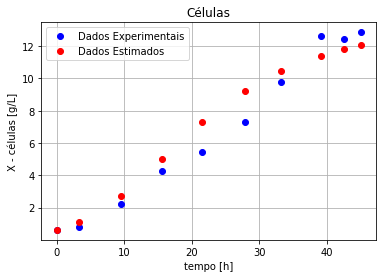

In [ ]:
fig2, ax2 = plt.subplots()
ax2.plot(dados.t_h, dados.X    , 'bo', label='Dados Experimentais')
ax2.plot(dados.t_h, dados.X_est, 'bo', label='Dados Estimados', color='red')
# Adicionando texto nos eixos - descrição
ax2.set_xlabel('tempo [h]')
ax2.set_ylabel('X - células [g/L]')
# Adicionando título para a figura
ax2.set_title('Células')
# Adicionando uma legenda
ax2.legend()
ax2.grid()

In [ ]:
r2 = r2_score(dados.X_est, dados.X)
r2

0.939210239254802

In [ ]:
MAE = mean_absolute_error(dados.X_est, dados.X)
MAE

0.8700721369964715

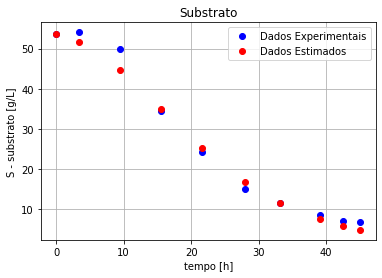

In [ ]:
fig3, ax3 = plt.subplots()
ax3.plot(dados.t_h, dados.S    , 'bo', label='Dados Experimentais')
ax3.plot(dados.t_h, dados.S_est, 'bo', label='Dados Estimados', color='red')
# Adicionando texto nos eixos - descrição
ax3.set_xlabel('tempo [h]')
ax3.set_ylabel('S - substrato [g/L]')
# Adicionando título para a figura
ax3.set_title('Substrato')
# Adicionando uma legenda
ax3.legend()
ax3.grid()

In [ ]:
r2 = r2_score(dados.S_est, dados.S)
r2

0.987205006850307

In [ ]:
MAE = mean_absolute_error(dados.S_est, dados.S)
MAE

1.51033300163884

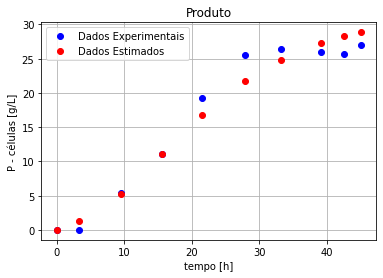

In [ ]:
fig4, ax4 = plt.subplots()
ax4.plot(dados.t_h, dados.P    , 'bo', label='Dados Experimentais')
ax4.plot(dados.t_h, dados.P_est, 'bo', label='Dados Estimados', color='red')
# Adicionando texto nos eixos - descrição
ax4.set_xlabel('tempo [h]')
ax4.set_ylabel('P - células [g/L]')
# Adicionando título para a figura
ax4.set_title('Produto')
# Adicionando uma legenda
ax4.legend()
ax4.grid()

In [ ]:
r2 = r2_score(dados.P_est, dados.P)
r2

0.9690198337697129

In [ ]:
MAE = mean_absolute_error(dados.P_est, dados.P)
MAE

1.4901721900311042